downlaod from fashion MNIST  
```
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
```
put them into data/fashion

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import imageio
from glob import glob
import scipy
import scipy.spatial
import pickle
import skimage
import skimage.transform
from skimage.color import rgb2gray
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

/Users/tdual/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/fashion', one_hot=True)

Extracting ./data/fashion/train-images-idx3-ubyte.gz
Extracting ./data/fashion/train-labels-idx1-ubyte.gz
Extracting ./data/fashion/t10k-images-idx3-ubyte.gz
Extracting ./data/fashion/t10k-labels-idx1-ubyte.gz


In [3]:
str_labels = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

In [4]:
img, label = mnist.train.next_batch(10)

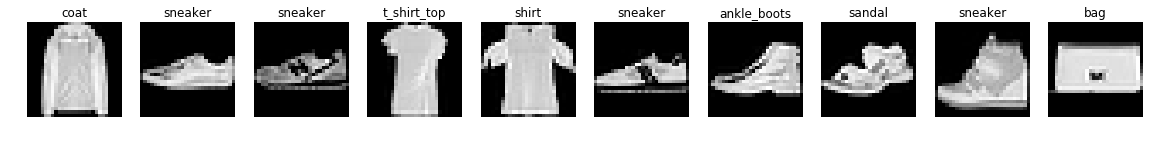

In [5]:
dim = 28

fig, axs = plt.subplots(1, len(img), figsize=(20, 3))

for i, (img, label )in enumerate(zip(img,label)):  
        axs[i].imshow(np.reshape(img, (dim, dim)),cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(str_labels[np.argmax(label)])
plt.show()

In [24]:
def weight_variable(shape):
    w = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(w)

def bias_variable(shape):
    b = tf.constant(0.1, shape=shape)
    return tf.Variable(b)

def conv2d(x, filt):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        filt is a filter. filt.shape is [filter_height, filter_width, in_channels, out_channels]
    """
    
    return tf.nn.conv2d(x, filt, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def variable_summaries(var):  
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        
def block(x, out_size, in_channel, name):
    with tf.name_scope("conv_{}".format(name)):
        with tf.name_scope('weights'):
            W_conv1 = weight_variable([5,5, in_channel, out_size])
            variable_summaries(W_conv1)        
        with tf.name_scope('biases'):
            b_conv1 = bias_variable([out_size])
            variable_summaries(b_conv1)
        h_conv1 = tf.nn.bias_add(conv2d(x, W_conv1), b_conv1)
        variable_summaries(h_conv1)
        
    with tf.name_scope("relu_{}".format(name)):
        h_conv1_act = tf.nn.relu(h_conv1)
    
    with tf.name_scope("pool_{}".format(name)):   
        h_pool1 = max_pool_2x2(h_conv1_act)
        variable_summaries(h_pool1)
    return h_pool1

In [25]:
height = 28
width = 28
image_size = height * width
g1 = None

with tf.Graph().as_default() as g1:
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, shape=[None, image_size], name='x-input')
        y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')

    with tf.name_scope('input_reshape'):    
        x_image = tf.reshape(x, [-1, height, width, 1])
        tf.summary.image('input',  x_image, 10)

    h_pool1 = block(x_image, 32, 1, "1")
    h_pool2 = block(h_pool1, 64, 32, "2")

    
    with tf.name_scope("pool2_flat"):
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    
    with tf.name_scope("fc1"):
        with tf.name_scope('weights'):
            W_fc1 = weight_variable([7 * 7 * 64, 1024])
        with tf.name_scope('biases'):   
            b_fc1 = bias_variable([1024])
        h_fc1 = tf.nn.bias_add(tf.matmul(h_pool2_flat, W_fc1), b_fc1)

    with tf.name_scope("relu3"):
        h_fc1_act = tf.nn.relu(h_fc1)
        
    with tf.name_scope("dropout"):
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1_act, keep_prob)

    with tf.name_scope("fc2"):
        with tf.name_scope('weights'):
            W_fc2 = weight_variable([1024,10])
        with tf.name_scope('biases'): 
            b_fc2 = bias_variable([10]) 
        y_conv = tf.nn.bias_add(tf.matmul(h_fc1_drop, W_fc2), b_fc2)

    with tf.name_scope("loss"):
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
        tf.summary.scalar('cross_entropy', loss)

    with tf.name_scope("optimizer"):
        opt = tf.train.AdamOptimizer(1e-4).minimize(loss)

    with tf.name_scope("accuracy"):
        correct = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        tf.summary.scalar('accuracy', accuracy)

In [26]:
import tensorboard as tb 
tb.show_graph(g1)

In [27]:
n_iter = 500
batch_size = 100
log_dir= "logs"
if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)



with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    
    for i in tqdm(range(n_iter)):
        batch = mnist.train.next_batch(batch_size)
        _ = sess.run(opt, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.6})
        
        if i % 100 == 0:
            train_loss, train_accuracy, summary = sess.run([loss, accuracy, merged], feed_dict={
                  x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, training loss %g, training accuracy %g' % (i, train_loss, train_accuracy))
            train_writer.add_summary(summary, i)
        
    test_accuracy, test_summary, = sess.run([accuracy, merged], 
                                           feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
    test_writer.add_summary(test_summary, 0)
    print('test accuracy %g' % test_accuracy)

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

step 0, training loss 7.46444, training accuracy 0.13
step 100, training loss 0.557455, training accuracy 0.84
step 200, training loss 0.511732, training accuracy 0.82
step 300, training loss 0.419606, training accuracy 0.85
step 400, training loss 0.38941, training accuracy 0.88

test accuracy 0.8306


```
tensorboard --logdir=logs
```

# similarity

In [ ]:
with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    h_fc1_ = sess.run(h_fc1, feed_dict={x: mnist.test.images})

In [ ]:
h_fc1_[0].shape

In [ ]:
from scipy.spatial import distance
pairwise = distance.squareform(distance.pdist(h_fc1_, metric="cosine"))

In [ ]:
def similar_to(img_id, num=5, distance=False):
    img = pairwise[img_id]
    ids = np.argsort(img)[0: num] 
    if distance:
        dist = np.sort(img)[0: num]
        return [(x,y) for x, y in zip(ids, dist)]
    else:
        return ids

def show_sim_image(img_id, num=5):
    id_list = similar_to(img_id, num=num,distance=True)
    fig, axs = plt.subplots(1, len(id_list), figsize=(20, 3))
    for i, id in enumerate(id_list):
        print(id)
        img =imgs[id[0]]
        axs[i].imshow(255 - np.reshape(img,[28,28]),cmap='gray')
        axs[i].axis('off')
    plt.show()

In [ ]:
imgs = mnist.test.images

In [ ]:
show_sim_image(4, 10)

In [ ]:
show_sim_image(0, 10)

# Visualization
ref: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/


In [ ]:
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = os.path.join(os.getcwd(), log_dir, 'visualization')


if tf.gfile.Exists(LOG_DIR):
    tf.gfile.DeleteRecursively(LOG_DIR)
tf.gfile.MakeDirs(LOG_DIR)

In [ ]:
labels = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
with open(os.path.join(LOG_DIR, 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index, label in enumerate(mnist.test.labels):
        f.write("%d\t%s\n" % (index, labels[np.argmax(label)]))

In [ ]:
rows =[]
columns = []
sprite_size = int(np.sqrt(len(mnist.test.images)))

print("sprite image size {size} * {size}".format(**{"size": sprite_size}))

for img in mnist.test.images:
    img_ = 255 - np.reshape(img, [height, width]) # reshape and invert grayscale 
    rows.append(img_)

for i in range(sprite_size):
    columns.append(np.concatenate(rows[sprite_size * i : sprite_size * (i + 1)], axis=1))
    
image = np.concatenate(columns, axis=0).astype(np.uint8)
imageio.imwrite(os.path.join(LOG_DIR, 'sprite.png'), image)

In [ ]:
embedding_var = tf.Variable(mnist.test.images, name='mnist_pixels')
config = projector.ProjectorConfig()

embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')
embedding.sprite.image_path = os.path.join(LOG_DIR,  'sprite.png')
embedding.sprite.single_image_dim.extend([28, 28])

summary_writer = tf.summary.FileWriter(LOG_DIR)
projector.visualize_embeddings(summary_writer, config)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(LOG_DIR,  'model.ckpt'), 0)

```
tensorboard --logdir=logs/visualization/
```

# tradesy data
http://jmcauley.ucsd.edu/data/tradesy/


In [ ]:
imgs = glob(os.path.join("./data/tradesy/images", "*.jpg"))
imgs = np.sort(imgs)

In [ ]:
def imread(path):
    return imageio.imread(path)#.astype(np.float)

def get_resize_img(path, dim=28):
    img = imread(path)
    return skimage.transform.resize(img, [dim,dim, 3], mode="reflect")

def get_flatten_img(path, dim=28, invert_gray=False):
    if invert_gray:
        img = 255 - imread(path)
    else:
        img = imread(path)
    return rgb2gray(skimage.transform.resize(img, [dim, dim], mode="reflect"))

In [ ]:
test = imgs[:10]
dim = 28
fig, axs = plt.subplots(1, len(test), figsize=(20, 3))
for i, path in enumerate(test):
        axs[i].imshow(imread(path), cmap='gray')
        axs[i].axis('off')
plt.show()

In [ ]:
test = imgs[:10]
dim = 28
fig, axs = plt.subplots(1, len(test), figsize=(20, 3))
for i, path in enumerate(test):
        axs[i].imshow(get_resize_img(path,dim), cmap='gray')
        axs[i].axis('off')
plt.show()

In [ ]:
test = imgs[:10]
dim = 28
fig, axs = plt.subplots(1, len(test), figsize=(20, 3))
for i, path in enumerate(test):
        axs[i].imshow(get_flatten_img(path, invert_gray=True), cmap='gray')
        axs[i].axis('off')
plt.show()

In [ ]:
get_resize_img(path, dim).shape

In [ ]:
get_flatten_img(test[0], invert_gray=True).shape

In [ ]:
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = os.path.join(os.getcwd(), log_dir, 'visualization', "tradesy")

if tf.gfile.Exists(LOG_DIR):
    tf.gfile.DeleteRecursively(LOG_DIR)
tf.gfile.MakeDirs(LOG_DIR)

In [ ]:
test = imgs[:10000]

In [ ]:
rows =[]
columns = []
sprite_size = int(np.sqrt(len(test)))
test_images = []
orig_images = []

print("sprite image size {size} * {size}".format(**{"size": sprite_size}))
rm_list = []
for path in tqdm(test):
    img_ = get_resize_img(path , dim) 
    if img_.shape != (28,28,3,):
        print(path)
        print(img_.shape)
        rm_list.append(path)
    else:
        test_images.append(get_flatten_img(path, invert_gray=True))
        orig_images.append(imread(path))
        rows.append(img_)
print(len(rows))
for i in tqdm(range(sprite_size)):
    columns.append(np.concatenate(rows[sprite_size * i : sprite_size * (i + 1)], axis=1))
    
image = np.concatenate(columns, axis=0)
imageio.imwrite(os.path.join(LOG_DIR, 'sprite.png'), image)
for path in rm_list:
    test = np.delete(test, np.argwhere(test==path))
len(test) 

In [ ]:
test_images = np.array(test_images)

In [ ]:
test_images.shape

In [ ]:
test_images = np.reshape(test_images, [10000, 28*28])

In [ ]:
with open(os.path.join(LOG_DIR, 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index, label in enumerate(test):
        f.write("%d\t%s\n" % (index, label))

In [ ]:
embedding_var = tf.Variable(test_images, name='mnist_pixels')
config = projector.ProjectorConfig()

embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')
embedding.sprite.image_path = os.path.join(LOG_DIR,  'sprite.png')
embedding.sprite.single_image_dim.extend([28, 28])

summary_writer = tf.summary.FileWriter(LOG_DIR)
projector.visualize_embeddings(summary_writer, config)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(LOG_DIR,  'model.ckpt'), 0)


```
tensorboard --logdir=logs/visualization/tradesy
```

In [ ]:
with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    h_fc1_ = sess.run(h_fc1, feed_dict={x: test_images})

In [ ]:
from scipy.spatial import distance
pairwise = distance.squareform(distance.pdist(h_fc1_, metric="cosine"))

In [ ]:
def similar_to(img_id, num=5, distance=False):
    img = pairwise[img_id]
    ids = np.argsort(img)[0: num] 
    if distance:
        dist = np.sort(img)[0: num]
        return [(x,y) for x, y in zip(ids, dist)]
    else:
        return ids

def show_sim_image(img_id, num=5):
    id_list = similar_to(img_id, num=num,distance=True)
    fig, axs = plt.subplots(1, len(id_list), figsize=(20, 3))
    for i, id in enumerate(id_list):
        print(id)
        img =orig_images[id[0]]
        axs[i].imshow(img ,cmap='gray')
        axs[i].axis('off')
    plt.show()

In [ ]:
show_sim_image(0,10)

In [ ]:
show_sim_image(1,10)

In [ ]:
len(h_fc1_)

In [ ]:
with open("mnist_feature.pkl", "wb") as f:
    pickle.dump(h_fc1_, f)